In [1]:
import numpy as np
import astropy
import ccdproc
from ccdproc import CCDData, Combiner
from astropy import units as u
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
import matplotlib.mlab as mlab
from photutils import centroid_com, centroid_1dg, centroid_2dg
from photutils import CircularAperture
from photutils import aperture_photometry
from photutils import Background2D
from photutils import MedianBackground
from photutils import DAOStarFinder
from photutils import detect_sources, deblend_sources, source_properties
from scipy.ndimage import shift
import gc                                                           
gc.enable()

from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia



ModuleNotFoundError: No module named 'numpy'

In [9]:
median = ccdproc.ImageFileCollection(".", glob_include="NGC_5139_*_median1.fits")
print(median.files)

scim = [CCDData.read(fn, unit = "adu") for fn in median.files_filtered()]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file.


['NGC_5139_B_median1.fits', 'NGC_5139_I_median1.fits', 'NGC_5139_R_median1.fits', 'NGC_5139_V_median1.fits']
INFO: using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file. [astropy.nddata.ccddata]


In [10]:
class Star:
    def __init__(self):
            self.name = "Default name"                                # Object name
            self.filename = "NULL                                  "  # Image file name
            self.ra = -99.0                                           # J2000 coords ra+dec (initially given dummy values)
            self.dec = -99.0
            self.x = -99.0                                            # CCD pixel coords x-y (intially given dummy values)
            self.y = -99.0
            self.flux = [-99.0,-99.0,-99.0,-99.0,-99.0]               # UBVRI Fluxes (intially given dummy values)
            self.mag = [-99.0,-99.0,-99.0,-99.0,-99.0]                # UBRRI Magnitudes (intially given dummy values)
            self.gaiamag = [-99.0, -99.0, -99.0]                      # G_BP, G and G_RP Magnitudes (intially given dummy values)
            self.exptime = 1.0
            self.airmass = 1.0
            
            
# This reads in the photometry from the Graham (1982) standard star photometry and converts to decimal degrees

def readgraham(fname):
    
    gstandards=[]

    with open(fname) as f:
        grahamtext = f.readlines()
    
    for imx, thisline in enumerate(grahamtext): 

        # Read in coordinates - each variable has specific columns, defined in the README file
        rah=float(thisline[15:17])   # Read in RA hours from the ASCII, and covert to float
        ram=float(thisline[18:20])   # Read in RA minutes from the ASCII, and covert to float
        ras=float(thisline[21:25])   # Read in RA seconds from the ASCII, and covert to float
        decd=float(thisline[27:29])  # Read in Dec degreess from the ASCII, and convert to float
        decm=float(thisline[30:32])  # Read in Dec arcminutes from the ASCII, and convert to float
        decs=float(thisline[33:35])  # Read in Dec arcseconds from the ASCII, and convert to float
        
        # Convert the coordinates to decimal degrees. 
        ra=15.0*(rah+ram/60.0+ras/3600.0)   # Convert RA to decimal degrees
        dec=decd+decm/60.0+decs/3600.0      # Convert Declination to decimal degrees
        if thisline[26]=='-':               # If the declination is negative, convert accordingly
            dec=0-dec
    
        # Read in the photometry 
        tmag=[-99.0,-99.0,-99.0,-99.0,-99.0]        # Temporary UBVRI magnitude list - initially unphysical values 
        tmag[2]=float(thisline[36:41])              # Read V magnitude from thisline and convert to float
        tmag[1]=float(thisline[50:56])+tmag[2]      # Read in B-V colour from thisline, convert to float, produce B magnitude.
        if (thisline[47]!=' '):
            tmag[0]=float(thisline[50:56])+tmag[1]  # Read in U-B colour from thisline (if available), convert to float, produce U magnitude
        tmag[3]=tmag[2]-float(thisline[57:62])      # Read in V-R colour from thisline, convert to float, prodcue R magnitude
        if (thisline[68]!=' '):
            tmag[4]=tmag[3]-float(thisline[64:69])  # Read in R-I colour from thisline, convert to float, produce I magnitude 
        
        # Create temporary tstandard, which has class star, and populate it with data from Graham (1982)
        tstandard=Star()                            # Create tstandard with class star
        tstandard.name=thisline[0:12]               # Get the name from thisline
        tstandard.ra=ra                             # Get the RA
        tstandard.dec=dec                           # Get the Declination
        tstandard.mag=tmag                          # Get the UBVRI magnitudes
        
        # Extend the list gstandards with tstandard
        gstandards.extend([tstandard])

    # The end of the indentation is where there's the end of the for-loop
    
    # The end of the function, which returns the list of Graham Standards names, coordinates and UBVRI magnitudes 
    return gstandards


In [11]:
# To run function above we must run..
gstandards=readgraham('Graham1982.txt')
print(len(gstandards))
print(gstandards[0].ra, gstandards[0].dec, gstandards[0].mag)

102
21.174583333333334 -44.52833333333333 [8.562, 7.4159999999999995, 6.27, 5.699999999999999, 5.1899999999999995]


In [58]:
#Using the graham standard stars found previously to define Gaia stars (getgaia)
def getgaia(gstandards):
    
    #index defined as obj in gstandards
    for obj in gstandards:
        
        coord = SkyCoord(ra=obj.ra, dec=obj.dec, unit=(u.degree, u.degree), frame='icrs') #Defining the coordinates through each star in gstandards in units of degrees
        radius = u.Quantity(0.001, u.deg)              #Defining the radius of the star to units 0.001 degrees
        j = Gaia.cone_search_async(coord, radius)      #Performs a conesearch of the star with set coordinates and radius
        r = j.get_results()                            #Returns the query j as an array of coordinates and radius
        if len(r)>0:
            obj.gaiamag[0]=r[0]['phot_bp_mean_mag']    
            obj.gaiamag[1]=r[0]['phot_g_mean_mag']
            obj.gaiamag[2]=r[0]['phot_rp_mean_mag']
    return gstandards


#Reading the csv graham_data file
i=0  # If i=1 then query the GAIA database
if i==1:
    gstandards=getgaia(gstandards)
    f=open("graham_gaia.csv", "w")                              #Prepared csv file for Gaia and open, "w" emptys the file before text below is inserted at current position
    f.write("Name, RA_J2000,DEC_J2000,U,B,V,R,I,G_BP,G,G_RP\n") #Writes specific text to the file 
    for obj in gstandards:
        f.write("%s , " % obj.name)             #Inserts objname and adds 's' at the end
        f.write("%9.5f , " % obj.ra)            #Inserts ra of obj in gstandards and adds '9.5f'. Why 9.5f? Is this the conversion from Gaia filters to graham?
        f.write("%9.5f , " % obj.dec)
        f.write("%6.3f , " % obj.mag[0])       #U mag
        f.write("%6.3f , " % obj.mag[1])       #B mag
        f.write("%6.3f , " % obj.mag[2])       #V mag
        f.write("%6.3f , " % obj.mag[3])       #R mag
        f.write("%6.3f , " % obj.mag[4])       #I mag
        f.write("%6.3f , " % obj.gaiamag[0])   #G_BP
        f.write("%6.3f , " % obj.gaiamag[1])   #G mag
        f.write("%6.3f \n" % obj.gaiamag[2])   #G_RP
    f.close()
    

#Loading the Graham and GAIA photometry into existing file - because we did this in Lab_4 we do not need to do it again
grgaia=[]
f=open("graham_gaia.csv", "r")
grahamtext = f.readlines()
for line in grahamtext:
    currentline = line.split(",")
    if currentline[0]!="Name":                      #If the currentline does not include "Name" set the following values to that star
        tstandard=Star()
        tstandard.name=currentline[0]   
        tstandard.ra=float(currentline[1])          #Converts the current line to a float and sets to the dec in tsstandard stars list Stars()
        tstandard.dec=float(currentline[2])
        tstandard.mag[0]=float(currentline[3])      #Converts index 3 to float and sets to the magnitude of star 0 in strandard stars 
        tstandard.mag[1]=float(currentline[4])
        tstandard.mag[2]=float(currentline[5])
        tstandard.mag[3]=float(currentline[6])
        tstandard.mag[4]=float(currentline[7])
        tstandard.gaiamag[0]=float(currentline[8]) #Convrts index 8 to float and sets to the Gaia magnitude at index 0 of starndard stars
        tstandard.gaiamag[1]=float(currentline[9])
        tstandard.gaiamag[2]=float(currentline[10])
        grgaia.extend([tstandard])
f.close()

Vpoly: 
[0.48446054 0.22184931 0.00858087]


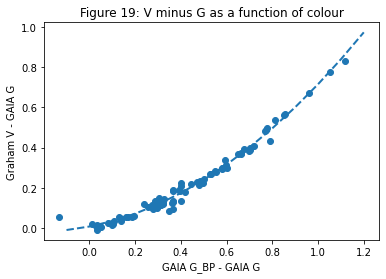

In [59]:
# Finding V Magnitude
# Plot the difference between V and G as a function of GAIA G_BP and G.

px=[]                                                 #Creats an empty list p
py=[]                                                 #Creats an empty list p

#Sorts through each object in GRGAIA as define in task 7
for obj in grgaia:
    
    #If the object in gaiamag list at index 2 is greater than 0, AND is less than 20 and gaiamag at index 0 and 1 is greater than 20 etc
    if obj.mag[2]>0.0 and obj.mag[2]<20.0 \
    and obj.gaiamag[0]>0.0 and obj.gaiamag[0]<20.0 \
    and obj.gaiamag[1]>0.0 and obj.gaiamag[1]<20.0 \
    and (obj.mag[2]-obj.gaiamag[1])**2<2.25 :
        px.append(obj.gaiamag[0]-obj.gaiamag[1])      # G_BP minus G
        py.append(obj.mag[2]-obj.gaiamag[1])          # V minus G
        
Vpoly=np.polyfit(px, py, 2)                           #Creates a polynomial relationship between px and py with degree of fitting 2  
print("Vpoly: ")
print(Vpoly)                                          

plx=np.arange(-0.1, 1.3, 0.1).tolist()                #Plx is a range of numbers between -0.1 and 1.3 with interval 0.1 and converts to a list
ply=[]                                                #Create empty ply list
for x in plx:
    ply.append(Vpoly[2]+Vpoly[1]*x+Vpoly[0]*x*x)      #Adds values from 

plt.title('Figure 19: V minus G as a function of colour')        #Plots Poly title 
plt.ylabel('Graham V - GAIA G')                       #Plots y and x label
plt.xlabel('GAIA G_BP - GAIA G')
plt.scatter(px, py, marker='o');                      #Plots as a scatter plot
plt.plot(plx, ply, linestyle='dashed', linewidth=2);  #Plot values and design to fit

<font color=green>Choosing Reference star x=1646, y=798 and find in Aladin at RA=201.1406238880 and Dec=-47.4332210973</font>

Rpoly: 
[0.40048953 0.33460064 0.01283236]


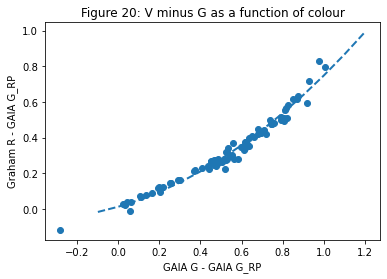

In [60]:
# Finding R Magnitude
# Plot the difference between R and G_RP as a function of G - G_RP

pa=[]                                                 #Creats an empty list pa (=px)
pb=[]                                                 #Creats an empty list pb (=py)

#Sorts through each object in GRGAIA as define in task 7
for obj in grgaia:
    
    #If the object in gaiamag list at index 2 is greater than 0, AND is less than 20 and gaiamag at index 0 and 1 is greater than 20 etc
    if obj.mag[3]>0.0 and obj.mag[3]<20.0 \
    and obj.gaiamag[1]>0.0 and obj.gaiamag[1]<20.0 \
    and obj.gaiamag[2]>0.0 and obj.gaiamag[2]<20.0 \
    and (obj.mag[3]-obj.gaiamag[2])**2<2.25 : #r - grp
        pa.append(obj.gaiamag[1]-obj.gaiamag[2])      #  X = G minus G_RP
        pb.append(obj.mag[3]-obj.gaiamag[2])          #  Y = R minus G_RP
        
# What is this doing?
Rpoly=np.polyfit(pa, pb, 2)                           #Creates a polynomial relationship between px and py with degree of fitting 2  
print("Rpoly: ")
print(Rpoly) 

pla=np.arange(-0.1, 1.3, 0.1).tolist()                #Pla is a range of numbers between -0.1 and 1.3 with interval 0.1 and converts to a list
plb=[]                                                #Create empty ply list
for x in pla:
    plb.append(Rpoly[2]+Rpoly[1]*x+Rpoly[0]*x*x)      #Adds values from 

# What are these lines doing?    
plt.title('Figure 20: V minus G as a function of colour')        #Plots Poly title 
plt.ylabel('Graham R - GAIA G_RP')                       #Plots y and x label
plt.xlabel('GAIA G - GAIA G_RP')
plt.scatter(pa, pb, marker='o');                      #Plots as a scatter plot
plt.plot(pla, plb, linestyle='dashed', linewidth=2);



In [54]:
gbp=[]
grp=[]
g=[]

for obj in grgaia:
    
    if 

b_grp=[]
r_grp=[]
i_grp=[]
v_g=[]
g_grp=[]
gbp_g=[]


for obj in grgaia:
    
    if obj.mag[1]>0.0 and obj.mag[1]<20.0 \
    and obj.gaiamag[2]>0.0 and obj.gaiamag[2]<20.0 \
    and (obj.mag[1]-obj.gaiamag[2])**2<2.25:
        b_grp.append(obj.mag[1] - obj.gaiamag[2])    #B - GRP
        
    if obj.mag[3]>0.0 and obj.mag[3]<20.0 \
    and obj.gaiamag[2]>0.0 and obj.gaiamag[2]<20.0 \
    and (obj.mag[3]-obj.gaiamag[2])**2<2.25:
        r_grp.append(obj.mag[3] - obj.gaiamag[2])    #R - GRP
        
    if obj.mag[4]>0.0 and obj.mag[4]<20.0 \
    and obj.gaiamag[2]>0.0 and obj.gaiamag[2]<20.0 \
    and (obj.mag[4]-obj.gaiamag[2])**2<2.25:
        i_grp.append(obj.mag[4] - obj.gaiamag[2])    #I - GRP
        
    if obj.mag[2]>0.0 and obj.mag[2]<20.0 \
    and obj.gaiamag[1]>0.0 and obj.gaiamag[1]<20.0 \
    and (obj.mag[2]-obj.gaiamag[1])**2<2.25:
        v_g.append(obj.mag[2] - obj.gaiamag[1])      #V - G
        
    if obj.gaiamag[1]>0.0 and obj.gaiamag[1]<20.0 \
    and obj.gaiamag[2]>0.0 and obj.gaiamag[2]<20.0 \
    and (obj.gaiamag[1]-obj.gaiamag[2])**2<2.25:
        g_grp.append(obj.gaiamag[1] - obj.gaiamag[2]) #G - GRP
        
    if obj.gaiamag[0]>0.0 and obj.gaiamag[0]<20.0 \
    and obj.gaiamag[1]>0.0 and obj.gaiamag[1]<20.0 \
    and (obj.gaiamag[0]-obj.gaiamag[1])**2<2.25:
        gbp_g.append(obj.gaiamag[0] - obj.gaiamag[1]) #GBP - G




Bpoly: 
[ 0.07103811  1.34863939 -0.02344701]


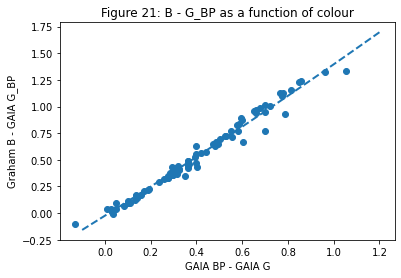

In [61]:
# Finding B Magnitude
# Plot the difference between B - G_BP as a function of G_BP - G

pa=[]                                                 #Creats an empty list pa (=px)
pb=[]                                                 #Creats an empty list pb (=py)

#Sorts through each object in GRGAIA as define in task 7
for obj in grgaia:
    
    #If the object in gaiamag list at index 2 is greater than 0, AND is less than 20 and gaiamag at index 0 and 1 is greater than 20 etc
    if obj.mag[1]>0.0 and obj.mag[1]<20.0 \
    and obj.gaiamag[0]>0.0 and obj.gaiamag[0]<20.0 \
    and obj.gaiamag[1]>0.0 and obj.gaiamag[1]<20.0 \
    and (obj.mag[1]-obj.gaiamag[0])**2<2.25 :
        pa.append(obj.gaiamag[0]-obj.gaiamag[1])      #  X = G_BP - G
        pb.append(obj.mag[1]-obj.gaiamag[0])          #  Y = B - G_BP
        
# What is this doing?
Bpoly=np.polyfit(pa, pb, 2)                           #Creates a polynomial relationship between px and py with degree of fitting 2  
print("Bpoly: ")
print(Bpoly) 

pla=np.arange(-0.1, 1.3, 0.1).tolist()                #Pla is a range of numbers between -0.1 and 1.3 with interval 0.1 and converts to a list
plb=[]                                                #Create empty ply list
for x in pla:
    plb.append(Bpoly[2]+Bpoly[1]*x+Bpoly[0]*x*x)      #Adds values from 

# What are these lines doing?    
plt.title('Figure 21: B - G_BP as a function of colour')        #Plots Poly title 
plt.ylabel('Graham B - GAIA G_BP')                              #Plots y and x label
plt.xlabel('GAIA BP - GAIA G')
plt.scatter(pa, pb, marker='o');                                #Plots as a scatter plot
plt.plot(pla, plb, linestyle='dashed', linewidth=2);

89 89
Ipoly: 
[ 0.03028805 -0.16889089  0.00466699]


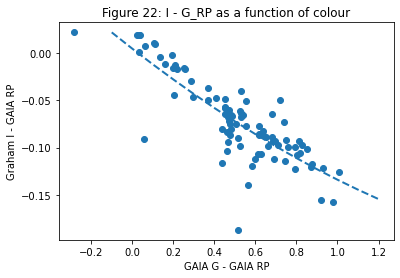

In [36]:
# Finding I Magnitude
# Plot the difference between I - G_RP as a function of G - G_RP

pa=[]                                                 #Creats an empty list pa (=px)
pb=[]                                                 #Creats an empty list pb (=py)

#Sorts through each object in GRGAIA as define in task 7
for obj in grgaia:
    
    #If the object in gaiamag list at index 2 is greater than 0, AND is less than 20 and gaiamag at index 0 and 1 is greater than 20 etc
    if obj.mag[4]>0.0 and obj.mag[4]<20.0 \
    and obj.gaiamag[1]>0.0 and obj.gaiamag[1]<20.0 \
    and obj.gaiamag[2]>0.0 and obj.gaiamag[2]<20.0 \
    and (obj.mag[4]-obj.gaiamag[2])**2<2.25 :
        pa.append(obj.gaiamag[1]-obj.gaiamag[2])      #  X = G - G_RP
        pb.append(obj.mag[4]-obj.gaiamag[2])          #  Y = I - G_RP
        
# What is this doing?
Ipoly=np.polyfit(pa, pb, 2)                           #Creates a polynomial relationship between px and py with degree of fitting 2  
print("Ipoly: ")
print(Ipoly) 

pla=np.arange(-0.1, 1.3, 0.1).tolist()                #Pla is a range of numbers between -0.1 and 1.3 with interval 0.1 and converts to a list
plb=[]                                                #Create empty ply list
for x in pla:
    plb.append(Ipoly[2]+Ipoly[1]*x+Ipoly[0]*x*x)      #Adds values from 

# What are these lines doing?    
plt.title('Figure 22: I - G_RP as a function of colour')        #Plots Poly title 
plt.ylabel('Graham I - GAIA RP')                              #Plots y and x label
plt.xlabel('GAIA G - GAIA RP')
plt.scatter(pa, pb, marker='o');                                #Plots as a scatter plot
plt.plot(pla, plb, linestyle='dashed', linewidth=2);

In [62]:
# second reference Star coordinates using Aladin
gmag1=[-99.0, -99.0, -99.0]
coord1 = SkyCoord(ra=	201.52153221085, dec=	-47.39518238257, unit=(u.degree, u.degree), frame='icrs')
radius1 = u.Quantity(0.001, u.deg)
j1 = Gaia.cone_search_async(coord1, radius1)
r1 = j1.get_results()
if len(r1)>0:
    gmag1[0]=r1[0]['phot_bp_mean_mag'] 
    gmag1[1]=r1[0]['phot_g_mean_mag']
    gmag1[2]=r1[0]['phot_rp_mean_mag']
    print(gmag1)
    
gbp=gmag1[0]
g=gmag1[1]
grp=gmag1[2]

INFO:astropy:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
[11.111196, 10.829804, 10.156079]


Second reference star at pixel coords x=1399 y=166

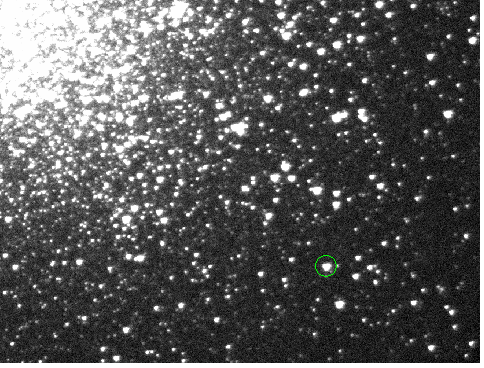

In [63]:
# GAIA - BVRI photometry relations to get magnitudes

# B Magnitude
GBP = gmag1[0]
GBPminusG = gmag1[0] - gmag1[1]
B = -0.03308 + 1.41139*GBPminusG + GBP
print('B Magnitude:', B)

# V Magnitude
G = gmag1[1]
GBPminusG = gmag1[0] - gmag1[1]
V = 0.00858 + 0.22184*GBPminusG + 0.48446*GBPminusG**2 + G
print('V Magnitude:', V)

# R magnitude
GRP = gmag1[2]
GminusGRP = gmag1[1] - gmag1[2]
R = 0.01283 + 0.33460*GminusGRP + 0.40048*GminusGRP**2 + GRP
print('R Magnitude:', R)

# I Magnitude
I = 0.00216 - 0.14069*GminusGRP + GRP
print('I Magnitude:', I)

B Magnitude: 11.475268210716248
V Magnitude: 10.939168247351667
R Magnitude: 10.576117814180662
I Magnitude: 10.063452904014587


### Model Approach - Median

In [88]:
# Model Approach - Median

median1 = ccdproc.ImageFileCollection(".",glob_include = 'NGC_5139_*_median1.fits')
scim = [CCDData.read(fn, unit = "adu") for fn in median1.files_filtered()]

files = median1.files
print("Print the files in median1")
print(median1.files)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file. [astropy.nddata.ccddata]
Print the files in median1
['NGC_5139_B_median1.fits', 'NGC_5139_I_median1.fits', 'NGC_5139_R_median1.fits', 'NGC_5139_V_median1.fits']


### V band

mean: -8.673475 median: -17.928701 stdev: 41.029114


 id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
  1  299.4304937432951 ...  1.963184406968304    -0.732402739788675
  2  835.5751608942485 ... 1.7412625576005847   -0.6021606536977444
  3   670.308034006221 ... 1.1394198361377896  -0.14170943952667725
  4 1215.2840269146384 ... 1.0083100380163008 -0.008985226842701949
  5  725.3065457404193 ...  5.462368351671304   -1.8434524579751774
  6 1390.6297615797964 ...  3.499372242046502   -1.3599753563988033
  7    900.01072935404 ...  3.489424659362625   -1.3568845646313985
  8 1021.8388095018566 ...  21.31870867152124     -3.32190223707098
  9  636.8145002067147 ... 1.2740240562158764   -0.2629440711427069
 10   784.516710078505 ... 4.5381290796009965   -1.6421921112881066
Length = 3025 rows
Min: -212.74176
Max: 58280.32
Stdev: 254.32803
Mean: 42.050846
 
 Photometry table for V band
 id      xcenter            ycenter           aperture_sum   
         

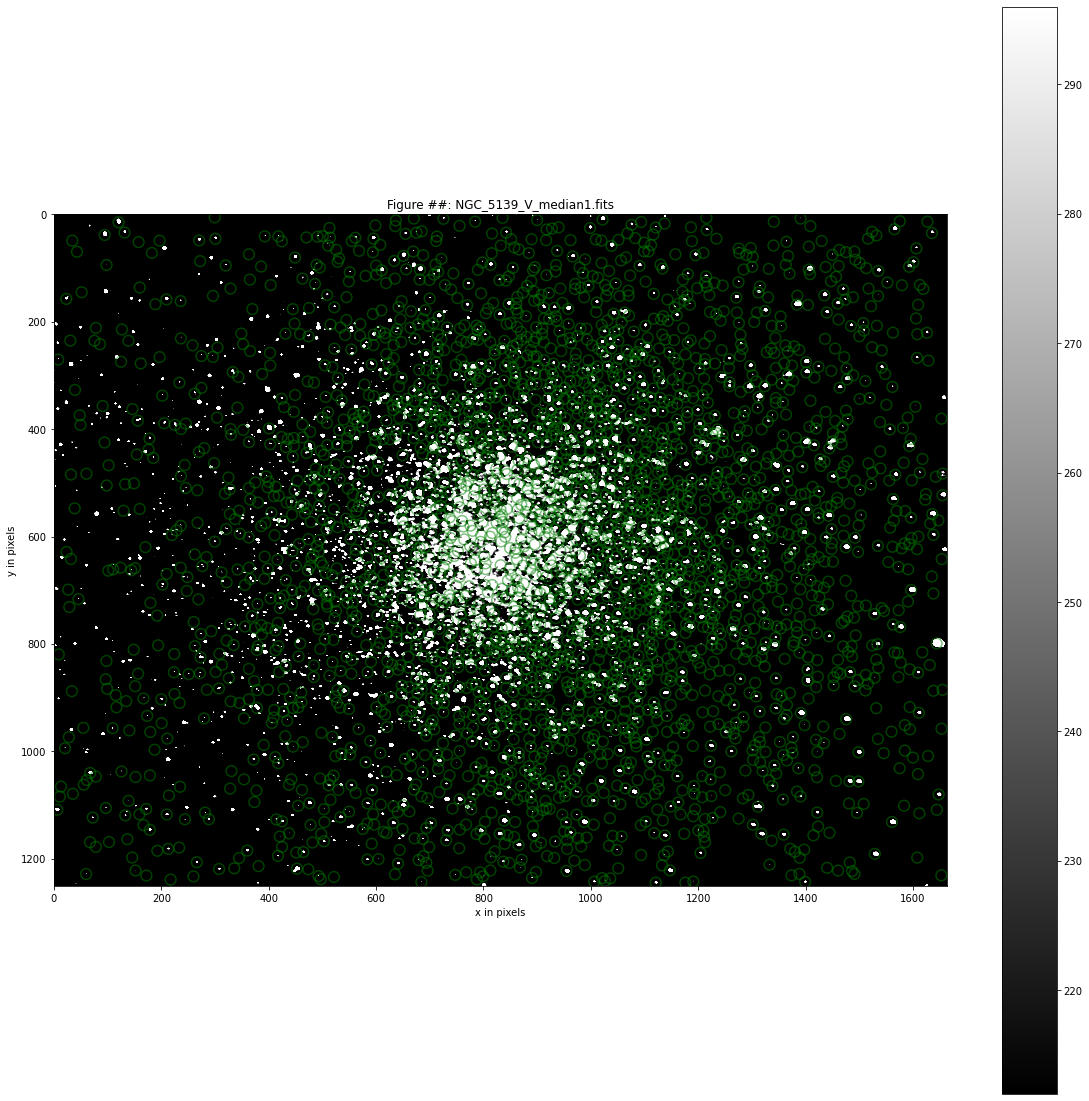

In [129]:
imdx=3 #NGC_5139_V_median1.fits

mean, median, std = astropy.stats.sigma_clipped_stats(scim[imdx].data, sigma=3.0, maxiters=5)
print('mean:', mean, 
      'median:', median,
      'stdev:', std)
daofind = DAOStarFinder(fwhm=10.0, threshold=5.*std, exclude_border=True)
sources_V = daofind(scim[imdx].data - median)
print(sources_V[0:10])
print("Length = %s rows" % len(sources_V))


print('Min:', np.min(scim[imdx]))
print('Max:', np.max(scim[imdx]))
print('Stdev:', np.std(scim[imdx]))
print('Mean:', np.mean(scim[imdx]))



#Cataloguing V median stars
print(" \n Photometry table for V band")
positionsV = (sources_V['xcentroid'], sources_V['ycentroid'])
aperturesV = CircularAperture(positionsV, r=10.0)

phot_tableV = aperture_photometry(scim[imdx].data - median, aperturesV)
print(phot_tableV[:10])
print("Length = %s rows" % len(phot_tableV), "\n")

# The reference star we will be offsetting the other images against
for obj in phot_tableV:
    if obj['xcenter'].value>1380 and obj['xcenter'].value<1400 \
    and obj['ycenter'].value>160 and obj['ycenter'].value<180:
        xv=obj['xcenter'].value
        yv=obj['ycenter'].value
        VFluxRef = obj['aperture_sum']
        
print("Ref star pixel coords: \n" ,xv, yv)
print("V band reference flux: \n", VFluxRef)




#Plot Median V band
plt.figure(figsize=(20,20))
plt.imshow(scim[imdx].data, cmap='gray', vmin=212, vmax=296)
plt.title('Figure ##: NGC_5139_V_median1.fits')
plt.ylabel('y in pixels')
plt.xlabel('x in pixels')
plt.colorbar()
aperturesV.plot(color='green', lw=1.5, alpha=0.5)
plt.savefig('Model_V_median1.pdf')

In [165]:
outfile="NGC_5139_V_median_model.fits"       
hdu=fits.PrimaryHDU(scim[imdx])                
hdu.writeto(outfile,overwrite="True")    

## B band

In [132]:
imdx=0 #NGC_5139_B_median1.fits

mean, median, std = astropy.stats.sigma_clipped_stats(scim[imdx].data, sigma=3.0, maxiters=5)
print('mean:', mean, 
      'median:', median,
      'stdev:', std)
daofind = DAOStarFinder(fwhm=10.0, threshold=5.*std, exclude_border=True)
sources_B = daofind(scim[imdx].data - median)
print(sources_B[0:10])
print("Length = %s rows" % len(sources_B))


print('Min:', np.min(scim[imdx]))
print('Max:', np.max(scim[imdx]))
print('Stdev:', np.std(scim[imdx]))
print('Mean:', np.mean(scim[imdx]))



# Cataloguing B median stars
print(" \n Dummy Photometry table for B band")
positionsB = (sources_B['xcentroid'], sources_B['ycentroid'])
aperturesB = CircularAperture(positionsB, r=10.0)

phot_tableB = aperture_photometry(scim[imdx].data - median, aperturesB)
print(phot_tableB[:10])
print("Length = %s rows" % len(phot_tableB), "\n")

for obj in phot_tableB:
    if obj['xcenter'].value>1365 and obj['xcenter'].value<1385 \
    and obj['ycenter'].value>160 and obj['ycenter'].value<180:
        xb=obj['xcenter'].value
        yb=obj['ycenter'].value
print("Ref star pixel coords: \n" ,xb, yb)

xb_off=xb-xv
yb_off=yb-yv
print("Offset values: \n" ,xb_off, yb_off )


#Applying offset values to B band catalogue
positions_B = (sources_V['xcentroid']+xb_off, sources_V['ycentroid']+yb_off) 
apertures_B = CircularAperture(positions_B, r=10.0)

phot_table_B = aperture_photometry(scim[imdx].data - median, apertures_B)
print(" \n Photometry table for B band: \n", phot_table_B[:10])
print("Length = %s rows" % len(phot_table_B), "\n")



#Finding flux of reference star in B band
for obj in phot_table_B:
    if obj['xcenter'].value>1365 and obj['xcenter'].value<1385 \
    and obj['ycenter'].value>160 and obj['ycenter'].value<180:
        print('B-average:')
        print('x=', obj['xcenter'].value, 'y=', obj['ycenter'].value,'flux=', obj['aperture_sum'])
        BFluxRef = obj['aperture_sum']
        

mean: -2.9880354 median: -5.78724 stdev: 25.424059


 id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
  1  517.4668200201262 ... 1.5110740618262313   -0.4482143770193056
  2 1126.3376375067342 ... 1.4647321265181188  -0.41439551801837143
  3   288.358604470051 ... 1.3432147371612109   -0.3203636201103483
  4  988.2393699572839 ...  1.404603587237824   -0.3688844330819223
  5  713.7680635747087 ...  1.899213898925687   -0.6964346997463865
  6 1011.0507085171023 ...  4.888979423049771   -1.7230455234752238
  7  888.6363207025595 ... 2.1654391600668133   -0.8388649658718337
  8  773.4353018042935 ... 1.7715023882431558   -0.6208543554044674
  9 1616.1908463625055 ... 1.0080519067509155 -0.008707238594939942
 10 108.68047644262536 ...  4.452261742487301    -1.621451720006013
Length = 2011 rows
Min: -138.94827
Max: 16153.738
Stdev: 60.93073
Mean: 5.2606854
 
 Dummy Photometry table for B band
 id      xcenter            ycenter           aperture_sum   
   

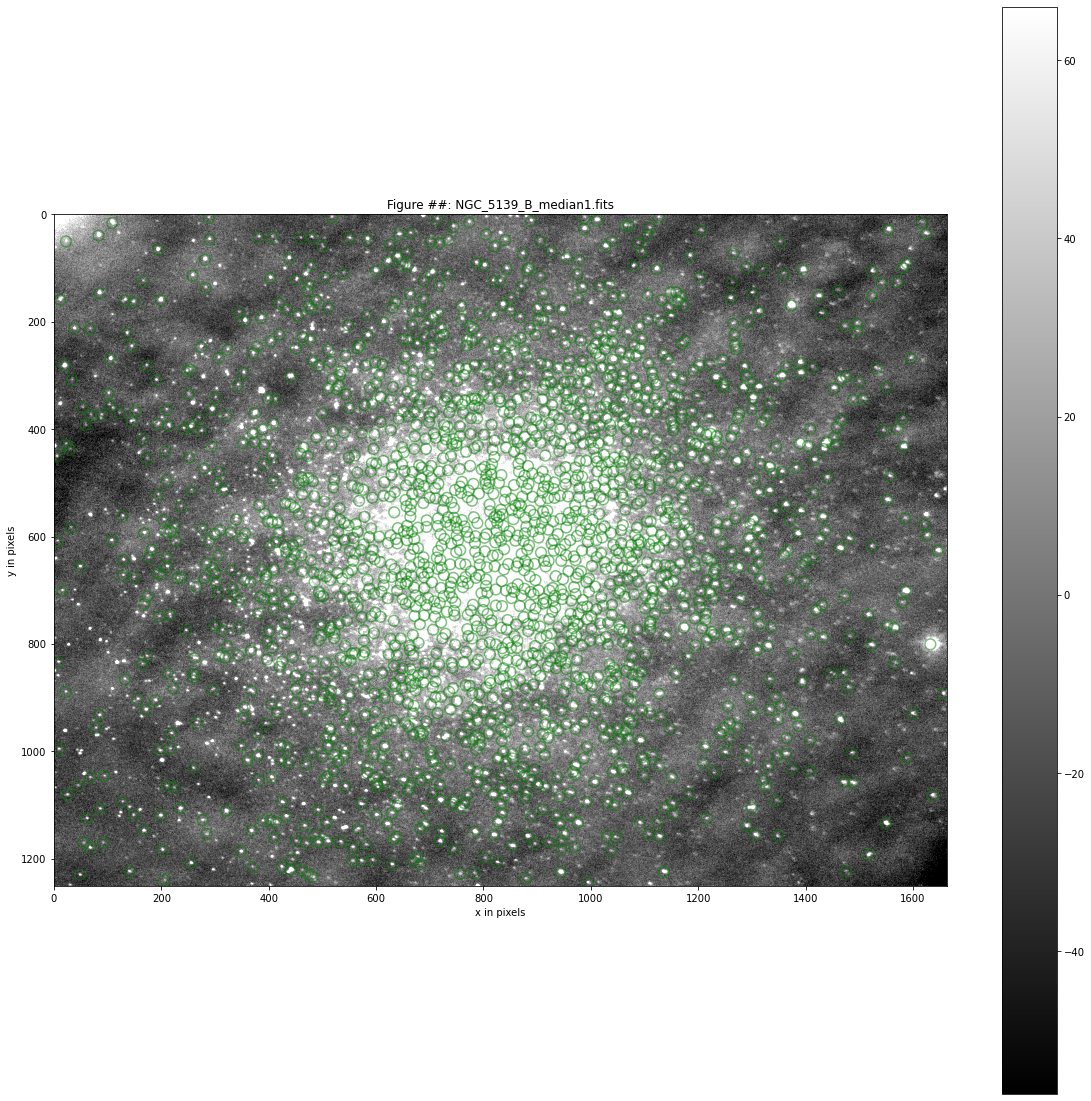

In [133]:
#Plot Median B band
plt.figure(figsize=(20,20))
plt.imshow(scim[imdx].data, cmap='gray', vmin=-56, vmax=66)
plt.title('Figure ##: NGC_5139_B_median1.fits')
plt.ylabel('y in pixels')
plt.xlabel('x in pixels')
plt.colorbar()
aperturesB.plot(color='green', lw=1.5, alpha=0.5)
plt.savefig('Model_B_median1.pdf')

In [164]:
outfile="NGC_5139_B_median_model.fits"       
hdu=fits.PrimaryHDU(scim[imdx])                
hdu.writeto(outfile,overwrite="True")    

## I band

In [151]:
imdx=1 #NGC_5139_I_median1.fits

mean, median, std = astropy.stats.sigma_clipped_stats(scim[imdx].data, sigma=3.0, maxiters=5)
print('mean:', mean, 
      'median:', median,
      'stdev:', std)
daofind = DAOStarFinder(fwhm=10.0, threshold=5.*std, exclude_border=True)
sources_I = daofind(scim[imdx].data - median)
print(sources_I[0:10])
print("Length = %s rows" % len(sources_I))


print('Min:', np.min(scim[imdx]))
print('Max:', np.max(scim[imdx]))
print('Stdev:', np.std(scim[imdx]))
print('Mean:', np.mean(scim[imdx]))




# Cataloguing I median stars
print(" \n Photometry table for I band")
positionsI = (sources_I['xcentroid'], sources_I['ycentroid'])
aperturesI = CircularAperture(positionsI, r=10.0)

phot_tableI = aperture_photometry(scim[imdx].data - median, aperturesI)
print(phot_tableI[:10])
print("Length = %s rows" % len(phot_tableI), "\n")

for obj in phot_tableI:
    if obj['xcenter'].value>1390 and obj['xcenter'].value<1410 \
    and obj['ycenter'].value>155 and obj['ycenter'].value<175:
        xi=obj['xcenter'].value
        yi=obj['ycenter'].value
print("Ref star pixel coords: \n" ,xi, yi)

xi_off=xi-xv
yi_off=yi-yv
print("Offset values: \n" ,xi_off, yi_off)


#Applying offset values to B band catalogue
positions_I = (sources_V['xcentroid']+xi_off, sources_V['ycentroid']+yi_off) 
apertures_I = CircularAperture(positions_I, r=10.0)

phot_table_I = aperture_photometry(scim[imdx].data - median, apertures_I)
print(" \n Photometry table for I band: \n", phot_table_I[:10])
print("Length = %s rows" % len(phot_table_I), "\n")




#Finding Flux of I band reference star
for obj in phot_tableI:
    if obj['xcenter'].value>1390 and obj['xcenter'].value<1410 \
    and obj['ycenter'].value>155 and obj['ycenter'].value<175:
        print('I-average:')
        print('x=', obj['xcenter'].value, 'y=', obj['ycenter'].value,'flux=', obj['aperture_sum'])
        IFluxRef = obj['aperture_sum']
        

mean: -4.677768 median: -14.130245 stdev: 39.431557


 id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
  1  737.5865083241555 ...  5.992511121170692   -1.9440221217240041
  2 1402.7985567550143 ...  2.024677037052441   -0.7658893933061752
  3   1033.97242336929 ...  29.84164007331534   -3.6870567198582616
  4  649.3798712195892 ... 1.0163364967489137 -0.017593803546385834
  5  796.6454334155095 ...  5.321632457904998   -1.8151121910327022
  6 1638.9697218368842 ...  3.532844588336857   -1.3703113325396596
  7 1105.8342508588696 ...  2.743621654666489   -1.0958105549232688
  8 1353.0863686023697 ... 1.1717126498493833  -0.17205279651359898
  9  132.8645372737832 ... 29.651851706702452   -3.6801295487104375
 10  1149.604338091221 ...  3.020938067681588   -1.2003545547093162
Length = 2046 rows
Min: -261.44476
Max: 24245.51
Stdev: 300.38376
Mean: 51.994774
 
 Photometry table for I band
 id      xcenter            ycenter           aperture_sum   
         

In [152]:
#Plot Median I band
plt.figure(figsize=(20,20))
plt.imshow(scim[imdx].data, cmap='gray', vmin=-56, vmax=66)
plt.title('Figure ##: NGC_5139_I_median1.fits')
plt.ylabel('y in pixels')
plt.xlabel('x in pixels')
plt.colorbar()
aperturesI.plot(color='green', lw=1.5, alpha=0.5)
plt.savefig('Model_I_median1.pdf')

In [163]:
outfile="NGC_5139_I_median_model.fits"       
hdu=fits.PrimaryHDU(scim[imdx])                
hdu.writeto(outfile,overwrite="True")    

## R band

In [161]:
imdx=2 #NGC_5139_R_median1.fits

mean, median, std = astropy.stats.sigma_clipped_stats(scim[imdx].data, sigma=3.0, maxiters=5)
print('mean:', mean, 
      'median:', median,
      'stdev:', std)
daofind = DAOStarFinder(fwhm=10.0, threshold=5.*std, exclude_border=True)
sources_R = daofind(scim[imdx].data - median)
print(sources_R[0:10])
print("Length = %s rows" % len(sources_R))


print('Min:', np.min(scim[imdx]))
print('Max:', np.max(scim[imdx]))
print('Stdev:', np.std(scim[imdx]))
print('Mean:', np.mean(scim[imdx]))




# Cataloguing R median stars
print(" \n Photometry table for R band")
positionsR = (sources_R['xcentroid'], sources_R['ycentroid'])
aperturesR = CircularAperture(positionsR, r=10.0)

phot_tableR = aperture_photometry(scim[imdx].data - median, aperturesR)
print(phot_tableR[:10])
print("Length = %s rows" % len(phot_tableR), "\n")

for obj in phot_tableR:
    if obj['xcenter'].value>1350 and obj['xcenter'].value<1370 \
    and obj['ycenter'].value>165 and obj['ycenter'].value<185:
        xr=obj['xcenter'].value
        yr=obj['ycenter'].value
print("Ref star pixel coords: \n" ,xr, yr)

xr_off=xr-xv
yr_off=yr-yv
print("Offset values: \n" ,xr_off, yr_off)


#Applying offset values to R band catalogue
positions_R = (sources_V['xcentroid']+xr_off, sources_V['ycentroid']+yr_off) 
apertures_R = CircularAperture(positions_R, r=10.0)

phot_table_R = aperture_photometry(scim[imdx].data - median, apertures_R)
print(" \n Photometry table for R band: \n", phot_table_R[:10])
print("Length = %s rows" % len(phot_table_R), "\n")




#Finding Flux of R band reference star
for obj in phot_tableR:
    if obj['xcenter'].value>1350 and obj['xcenter'].value<1360 \
    and obj['ycenter'].value>165 and obj['ycenter'].value<185:
        print('R-average:')
        print('x=', obj['xcenter'].value, 'y=', obj['ycenter'].value,'flux=', obj['aperture_sum'])
        RFluxRef = obj['aperture_sum']
         

mean: -6.687101 median: -14.131214 stdev: 39.417065


 id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  992.6943871332464 ...  1.310014734581703 -0.29319045118433235
  2  1347.320462489189 ...  4.874626030439039   -1.719853258216374
  3  546.8122383109132 ... 7.9348817164786976  -2.2488511430190767
  4  760.7720855669019 ... 3.1597075800995182  -1.2491172301017603
  5 1183.5126130744043 ... 1.1434637758432844 -0.14555602751529312
  6  245.9289758788707 ... 1.6348342596459318  -0.5336843255645107
  7  834.9556900874485 ... 2.8364627983405004  -1.1319427298598685
  8  673.2997317640995 ... 16.130790085363426  -3.0191390990846467
  9  848.3829501913448 ... 1.5166198596929028 -0.45219184661707723
 10  791.2039405525317 ... 3.7546455333273356  -1.4364223565552545
Length = 2467 rows
Min: -253.0
Max: 32521.723
Stdev: 237.36655
Mean: 39.615124
 
 Photometry table for R band
 id      xcenter            ycenter           aperture_sum   
           pix          

In [160]:
#Plot Median R band
plt.figure(figsize=(20,20))
plt.imshow(scim[imdx].data, cmap='gray', vmin=-50, vmax=500)
plt.title('Figure ##: NGC_5139_R_median1.fits')
plt.ylabel('y in pixels')
plt.xlabel('x in pixels')
plt.colorbar()
aperturesR.plot(color='green', lw=1.5, alpha=0.5)
plt.savefig('Model_R_median1.pdf')

In [162]:
outfile="NGC_5139_R_median_model.fits"       
hdu=fits.PrimaryHDU(scim[imdx])                
hdu.writeto(outfile,overwrite="True")    

## Magnitudes and Girardi Isochrones

In [167]:
# Magnitudes table against the reference star 
mV = V
maglistV = []

for obj in phot_tableV:
    f2 = obj['aperture_sum']
    m2 = 2.5*np.log10(VFluxRef/f2)+mV
    maglistV.append(m2)    
       
mI = I
maglistI = []

for obj in phot_table_I:
    f2 = obj['aperture_sum']
    m2 = 2.5*np.log10(IFluxRef/f2)+mI
    maglistI.append(m2)  

mB = B
maglistB = []

for obj in phot_table_B:
    f2 = obj['aperture_sum']
    m2 = 2.5*np.log10(BFluxRef/f2)+mB
    maglistB.append(m2) 
    
mR = R
maglistR = []

for obj in phot_table_R:
    f2 = obj['aperture_sum']
    m2 = 2.5*np.log10(RFluxRef/f2)+mR
    maglistR.append(m2) 


C:\Users\lucya\anaconda3\envs\obsastro2020\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
C:\Users\lucya\anaconda3\envs\obsastro2020\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
C:\Users\lucya\anaconda3\envs\obsastro2020\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log10
C:\Users\lucya\anaconda3\envs\obsastro2020\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in log10


In [459]:
class isochroneclass:
    def __init__(self):
            self.filename = "NULL                            "      # Relevant filename
            self.age = -99.0                                        # Age
            self.m = [-99.0]*1000                                   # Star masses
            self.U = [-99.0]*1000                                   # Star U-band magnitudes
            self.B = [-99.0]*1000                                   # Star B-band magnitudes
            self.V = [-99.0]*1000                                   # Star V-band magnitudes
            self.R = [-99.0]*1000                                   # Star R-band magnitudes
            self.I = [-99.0]*1000                                   # Star I-band magnitudes
            

fnames=['girardi_640e6', '960', '1440', '2160', '3240', '4860', '7290', '10935', '16402']
        
isochrone=[]

age=640
for fname in fnames:

    tchrone=isochroneclass()
    tchrone.age=age

    f=open(fname,"r")
    lines=f.readlines()
    idx=0
    for x in lines:
#        if x[0]=='#' and x[2]=='Z':
#            print(x.split()[28])
        if x[0]!='#' and idx<1000:
            tchrone.m[idx]=float(x.split()[5])   #Mass
            tchrone.U[idx]=float(x.split()[28])  
            tchrone.B[idx]=float(x.split()[29])
            tchrone.V[idx]=float(x.split()[30])
            tchrone.R[idx]=float(x.split()[31])
            tchrone.I[idx]=float(x.split()[32])
            idx=idx+1
    f.close()
    isochrone.append(tchrone)
    age=age*1.5

EBV=0.9 - (6.12-5.53)
RV=3.1*EBV 
DM=15-3.53    #3.53

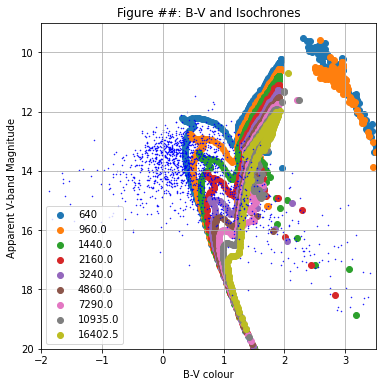

In [473]:
px = []
py = []
for idx, obj in enumerate(sources_V):
    #print(obj)
    if (obj['xcentroid']-858)**2 + (obj['ycentroid']-619)**2>300**2:
        py.append(maglistB[idx])
        px.append(maglistB[idx]- maglistV[idx])
    
    
plt.rcParams['figure.figsize'] = [6, 6]
plt.scatter(px, py,s=1, marker='.', color='blue')
plt.axis([-2,3.5, 20, 9])
plt.xlabel('B-V Color')
plt.ylabel('Aparent V-Magnitude')
plt.title('Figure ##: B-V vs App V magnitude')
plt.grid(True)
plt.show()


#Applying Girardi Iscochrones
for tiso in isochrone:
    BV=np.array(tiso.B)-np.array(tiso.V) +EBV
    V=np.array(tiso.V)+DM +RV
    plt.scatter(BV, V, label=str(tiso.age))  
plt.rcParams['figure.figsize'] = [6, 6]
plt.axis([-2,3.5, 20, 9])
plt.xlabel('B-V colour')          
plt.ylabel('Apparent V-band Magnitude ')
plt.title('Figure ##: B-V and Isochrones')
plt.grid(True)
plt.legend(loc='lower left')
plt.scatter(px, py,s=1, marker='.', color='blue') #B-V vs ap.mag
plt.show()


#Best fit iscochrone 4860Myr
plt.rcParams['figure.figsize'] = [6, 6]
plt.axis([-2,3.5, 20, 9])
plt.xlabel('B-V colour')          
plt.ylabel('Apparent V-band Magnitude ')
plt.title('Figure ##: B-V and Isochrone 4.860Gry')
plt.grid(True)
V=np.array(isochrone[1].V)+DM+RV
BV=np.array(isochrone[1].B)-np.array(isochrone[1].V)+EBV  #Isochrone 4.860Gyr
plt.scatter(BV, V, label=str(tiso.age))  
plt.scatter(px, py,s=1, marker='.', color='blue') #B-V vs ap.mag
plt.show()

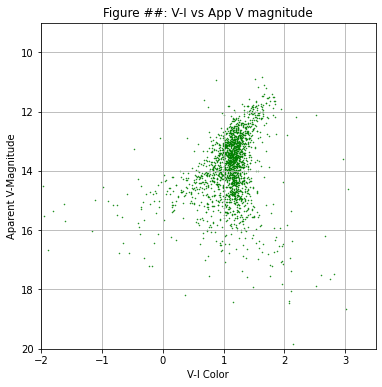

In [470]:
px = []
py = []
for idx, obj in enumerate(sources_V):
    if (obj['xcentroid']-858)**2 + (obj['ycentroid']-619)**2>300**2:
        py.append(maglistV[idx])
        px.append(maglistV[idx]- maglistI[idx])
    
    
plt.rcParams['figure.figsize'] = [6, 6]
plt.scatter(px, py,s=1, marker='.', color='green')
plt.axis([-2,3.5, 20, 9])
plt.xlabel('V-I Color')
plt.ylabel('Aparent V-Magnitude')
plt.title('Figure ##: V-I vs App V magnitude')
plt.grid(True)
plt.show()

#Applying Girardi Iscochrones
for tiso in isochrone:
    VI=np.array(tiso.V)-np.array(tiso.I) +EBV
    V=np.array(tiso.V)+DM +RV
    plt.scatter(VI, V, label=str(tiso.age)) 
plt.axis([-0.5,2, 18, 10])
plt.rcParams['figure.figsize'] = [6, 6]
plt.xlabel('V-I colour')          
plt.ylabel('Apparent V-band Magnitude ')
plt.title('Figure ##: V-I and Isochrones')
plt.grid(True)
plt.legend(loc='lower left')
plt.scatter(px, py,s=1, marker='.', color='green') #V-I vs ap.mag
plt.show()


#Best fit iscochrone 10935Myr
plt.rcParams['figure.figsize'] = [6, 6]
plt.xlabel('V-I colour')          
plt.ylabel('Apparent V-band Magnitude ')
plt.title('Figure ##: V-I and Isochrone 10.935Gry')
plt.axis([-2,3.5, 20, 9])
plt.grid(True)
V=np.array(isochrone[3].V)+DM+RV
VI=np.array(isochrone[3].V)-np.array(isochrone[3].I)+EBV#Isochrone 10.935Gyr
plt.scatter(VI, V, label=str(tiso.age))  
plt.scatter(px, py,s=1, marker='.', color='green') #V-I vs ap.mag
plt.show()

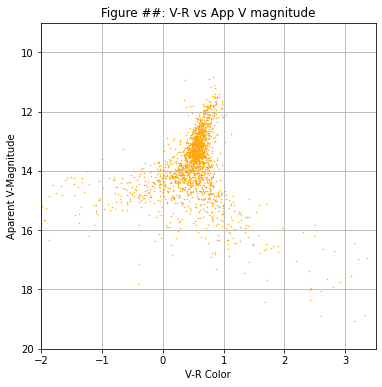

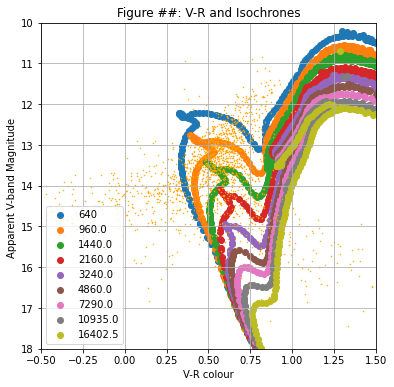

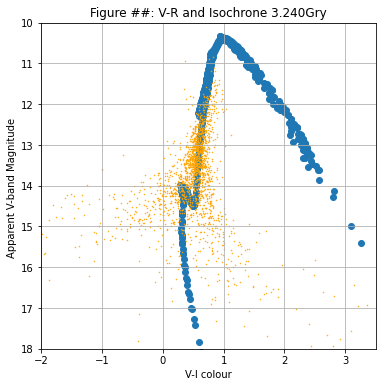

In [462]:
px = []
py = []
for idx, obj in enumerate(sources_V):
    if (obj['xcentroid']-858)**2 + (obj['ycentroid']-619)**2>300**2:
        py.append(maglistV[idx])
        px.append(maglistV[idx]- maglistR[idx])
        
        
plt.rcParams['figure.figsize'] = [6, 6]
plt.scatter(px, py,s=1, marker='.', color='orange')
plt.axis([-2,3.5, 20, 9])
plt.xlabel('V-R Color')
plt.ylabel('Aparent V-Magnitude')
plt.title('Figure ##: V-R vs App V magnitude')
plt.grid(True)
plt.show()


#Applying Girardi Iscochrones
for tiso in isochrone:
    VR=np.array(tiso.V)-np.array(tiso.R) +EBV
    V=np.array(tiso.V)+DM +RV
    plt.scatter(VR, V, label=str(tiso.age))  
plt.rcParams['figure.figsize'] = [6, 6]
plt.axis([-0.5,1.5, 18, 10])
plt.xlabel('V-R colour')          
plt.ylabel('Apparent V-band Magnitude ')
plt.title('Figure ##: V-R and Isochrones')
plt.grid(True)
plt.legend(loc='lower left')
plt.scatter(px, py,s=1, marker='.', color='orange') #V-I vs ap.mag
plt.show()


#Best fit iscochrone 3240Myr
plt.rcParams['figure.figsize'] = [6, 6]
plt.axis([-2,3.5, 18, 10])
plt.xlabel('V-I colour')          
plt.ylabel('Apparent V-band Magnitude ')
plt.title('Figure ##: V-R and Isochrone 3.240Gry')
plt.grid(True)
V=np.array(isochrone[4].V)+DM
VR=np.array(isochrone[4].V)-np.array(isochrone[4].R)#Isochrone 3.240Gyr
plt.scatter(VR, V, label=str(tiso.age))  
plt.scatter(px, py,s=1, marker='.', color='orange') #V-R vs ap.mag
plt.show()

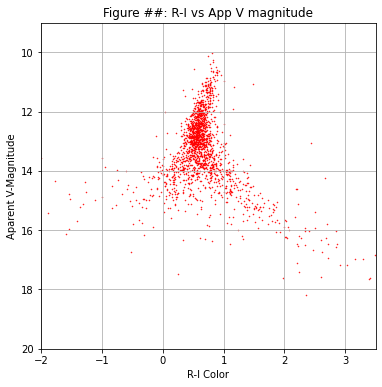

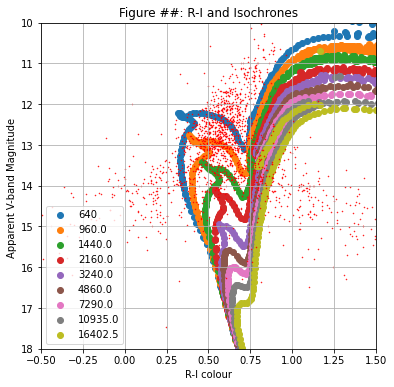

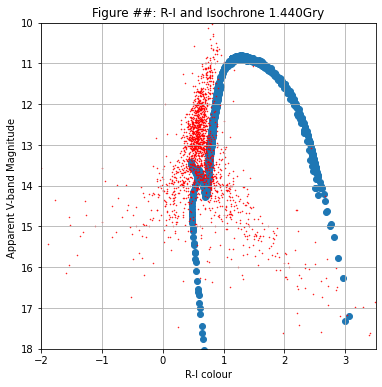

In [463]:
px = []
py = []
for idx, obj in enumerate(sources_V):
    if (obj['xcentroid']-858)**2 + (obj['ycentroid']-619)**2>300**2:
        py.append(maglistR[idx])
        px.append(maglistR[idx]- maglistI[idx])
        
        
plt.rcParams['figure.figsize'] = [6, 6]
plt.scatter(px, py,s=1, marker='.', color='red')
plt.axis([-2,3.5, 20, 9])
plt.xlabel('R-I Color')
plt.ylabel('Aparent V-Magnitude')
plt.title('Figure ##: R-I vs App V magnitude')
plt.grid(True)
plt.show()

#Applying Girardi Iscochrones
for tiso in isochrone:
    RI=np.array(tiso.R)-np.array(tiso.I) +EBV
    V=np.array(tiso.V)+DM +RV
    plt.scatter(RI, V, label=str(tiso.age))  
plt.rcParams['figure.figsize'] = [6, 6]
plt.axis([-0.5,1.5, 18, 10])
plt.xlabel('R-I colour')          
plt.ylabel('Apparent V-band Magnitude ')
plt.title('Figure ##: R-I and Isochrones')
plt.grid(True)
plt.legend(loc='lower left')
plt.scatter(px, py,s=1, marker='.', color='red') #R-I vs ap.mag
plt.show()


#Best fit iscochrone 1440Myr
plt.rcParams['figure.figsize'] = [6, 6]
plt.axis([-2,3.5, 18, 10])
plt.xlabel('R-I colour')          
plt.ylabel('Apparent V-band Magnitude ')
plt.title('Figure ##: R-I and Isochrone 1.440Gry')
plt.grid(True)
V=np.array(isochrone[2].V)+DM+RV
RI=np.array(isochrone[2].R)-np.array(isochrone[2].I)+EBV
plt.scatter(RI, V, label=str(tiso.age))  
plt.scatter(px, py,s=1, marker='.', color='red') #R-I vs ap.mag
plt.show()

## Distance

In [464]:
# Distance to NGC5139 using Abs mag=5.33 from REF#6,4
DM=15-3.53    
distance=10.0*pow(10,0.2*DM)
print(distance/1000, 'kpc')
print('Comparing to the literature distance of 5+-0.5kpc #2 and 4.8+-0.3kpc #9')

1.967886289706845 kpc
Comparing to the literature distance of 5+-0.5kpc #2 and 4.8+-0.3kpc #9


## Age

We can determine an estiomated age from the isochrones on the HR diagrams. 

## Uncertainties